## Load d2go Mask R-CNN model

In [1]:
import numpy as np
import os, json, cv2, random
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time
from d2go.model_zoo import model_zoo

In [3]:
# Display image
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

## Load custom dataset

In [5]:
dataset_path = './official+unofficial/train/' # path for dataset
anns_file_path = dataset_path + '_annotations.coco.json' # filename

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

# 3 main metadata in coco dataset
categories = dataset['categories'] # list of categories
anns = dataset['annotations'] # list of annotations
imgs = dataset['images']# list of images

In [6]:
img_df=pd.DataFrame(imgs)
ang_df=pd.DataFrame(anns)
cat_df=pd.DataFrame(categories)

print('Number of super categories:',len(cat_df.supercategory.unique()))
print('Number of categories:',len(cat_df.name.unique()))
print('Number of annotations:', len(ang_df))
print('Number of images:', len(img_df))

Number of super categories: 2
Number of categories: 18
Number of annotations: 7522
Number of images: 3121


In [6]:
# Display classes in dataset
cat_df.head(28)

id               name supercategory
0    0              trash          none
1    1          Aluminium         trash
2    2          Cardboard         trash
3    3             Carton         trash
4    4              Glass         trash
5    5       HDPE plastic         trash
6    6       LDPE plastic         trash
7    7        Other metal         trash
8    8      Other plastic         trash
9    9        PET plastic         trash
10  10         PP plastic         trash
11  11         PS plastic         trash
12  12        PVC plastic         trash
13  13              Paper         trash
14  14        Plastic bag         trash
15  15  Plastic packaging         trash
16  16    Snack packaging         trash
17  17              Steel         trash

In [7]:
# eliminate duplicates
val,counts=np.unique(ang_df.id,return_counts=True)
val[counts>1]
ang_df=ang_df[~ang_df.id.duplicated(keep="first")]

In [8]:
#Define column for super categories in annotations dataframe
ang_df["categories"]=ang_df["category_id"].apply(lambda value: categories[value]["name"] )

In [9]:
#BBOx mode
from detectron2.structures import BoxMode

ang_df["bbox_mode"]=BoxMode.XYWH_ABS

# Collective dataset of dictionaries of each TACO metadata
cocodata={"images":img_df[["id","width","height","file_name"]].to_dict("records"),#Cut index 
         "annotations":ang_df[['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox',
       'iscrowd', 'bbox_mode']].to_dict("records"),
          "categories":categories, "info":dataset["info"]}

## Split dataset into training and validation sets

In [10]:
#Save datadata as json
save_name="TACO_annotations.json"
json.dump(cocodata,open(save_name,"w"))


#Train eval split
img_id=list(range(1,len(cocodata["images"])+1))
np.random.seed=42
import random

# processes dictionary of data
def SplitDatadir(data_dict,img_ids):
    newdata_dict=copy.deepcopy(data_dict) #.copy()
    print("start, total number of images: ",len(newdata_dict["images"]),"total number of annotations:" , len(newdata_dict["annotations"]))
    #newdata_dict["images"]={}
    #newdata_dict["annotations"]={}
    
    newdata_dict["images"]=list(img for img in data_dict["images"] if img["id"] in img_ids)
    newdata_dict["annotations"]=list(ann for ann in data_dict["annotations"] if ann['image_id'] in img_ids)

    print("finish, total number of images: ",len(newdata_dict["images"]), "total number of annotations:" ,len(newdata_dict["annotations"]))
    return newdata_dict

#Split data set by 80% train, 20% eval
# Get the random image ids from the dataset for both train and validation set
train_id=random.sample(img_id,int((len(img_id))*0.8))
val_id=list([id for id in img_id if id not in train_id])
print("size of training data: ", len(train_id),", size of validation data: " , len(val_id))

# process and save training and validation data
train_dataset=SplitDatadir(cocodata,train_id)
json.dump(train_dataset,open(save_name.replace(".","_train."),"w"))
val_dataset=SplitDatadir(cocodata,val_id)
json.dump(val_dataset,open(save_name.replace(".","_val."),"w"))

size of training data:  2496 , size of validation data:  625
start, total number of images:  3121 total number of annotations: 7522
finish, total number of images:  2495 total number of annotations: 6107
start, total number of images:  3121 total number of annotations: 7522
finish, total number of images:  625 total number of annotations: 1413


In [11]:
# register coco dataset (TACO)
image_root=dataset_path
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
#from detectron2.data import MetadataCatalog, DatasetCatalog.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

label_paths={
   "train":save_name.replace(".","_train."),
   "val":save_name.replace(".","_val."),
    "all":save_name  #label_path,
}
for d in list(label_paths.keys()):
    dataset_name= f"TACO_{d}"
    if dataset_name in DatasetCatalog.list(): # ensures dataset is not already on DatasetCatalog list
    #DatasetCatalog.remove(dataset_name)
        DatasetCatalog.remove(dataset_name)
    register_coco_instances(dataset_name, {},label_paths[d], image_root) # register coco dataset (training and validation)

In [12]:
# get metadata for TACO dataset
#TACO_metadata = MetadataCatalog.get("TACO_train").set(thing_classes=['Aluminium foil', 'Battery', 'Blister pack', 'Bottle', 'Bottle cap', 'Broken glass', 'Can', 'Carton', 'Cigarette', 'Cup', 'Food waste', 'Glass jar', 'Lid', 'Other plastic', 'Paper', 'Paper bag', 'Plastic bag & wrapper', 'Plastic container', 'Plastic glooves', 'Plastic utensils', 'Pop tab', 'Rope & strings', 'Scrap metal', 'Shoe', 'Squeezable tube', 'Straw', 'Styrofoam piece', 'Unlabeled litter'])
#TACO_metadata = MetadataCatalog.get("TACO_train").set(thing_classes=['material-of-trash','Aluminium','Battery','Cardboard','Carton','Cigarette','Egg Carton','Glass','HDPE plastic', 'LDPE plastic','Other metal','Other plastic','PE plastic','PET plastic','PP plastic','PS plastic','PVC plastic','Paper','Paper packaging','Paper tissues','Plastic bag','Plastic bottle cap','Plastic packaging','Rope - strings','Snack packaging','Squeezable tube','Steel','Unlabeled litter'])
TACO_metadata = MetadataCatalog.get("TACO_train").set(thing_classes=['trash', 'Aluminium', 'Cardboard', 'Carton', 'Glass', 'HDPE plastic', 'LDPE plastic', 'Other metal', 'Other plastic', 'PET plastic', 'PP plastic', 'PS plastic', 'PVC plastic', 'Paper', 'Plastic bag', 'Plastic packaging', 'Snack packaging', 'Steel'])

## Training

In [16]:
import os
from d2go.model_zoo import model_zoo
from d2go.runner import GeneralizedRCNNRunner 

def prepare_for_launch():
    runner = GeneralizedRCNNRunner()
    cfg = runner.get_default_cfg()
    model="mask_rcnn_fbnetv3g_fpn.yaml" # mask_rcnn_fbnetv3g_fpn.yaml | mask_rcnn_fbnetv3a_C4.yaml
    cfg.merge_from_file(model_zoo.get_config_file(f"{model}"))
    cfg.MODEL_EMA.ENABLED = False
    cfg.DATASETS.TRAIN = ("TACO_train",)
    cfg.DATASETS.TEST = ("TACO_val",)
    cfg.DATALOADER.NUM_WORKERS = 0 
    cfg.OUTPUT_DIR=f"./output/{model}"
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    #cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model) #weighting 
    
    cfg.MODEL.DEVICE = "cuda" #if ('CI' in os.environ) else "cuda" / "cpu" for cpu
    #cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("mask_rcnn_fbnetv3g_fpn.yaml")  # Let training initialize from model zoo
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 #(512 try)   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(categories)  
    #cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 #Test threshold 
    
    # Learning rate settings
    cfg.SOLVER.IMS_PER_BATCH = 2 # batch size
    cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
    cfg.SOLVER.MAX_ITER = 3000
    cfg.SOLVER.GAMMA = 0.5 # play with this later (and steps)
    #cfg.SOLVER.WARMUP_ITERS = 1500  
    cfg.SOLVER.STEPS = []        # do not decay learning rate
    cfg.SOLVER.LR_SCHEDULER_NAME= "WarmupMultiStepLR"
    
    '''
    cfg.QUANTIZATION.BACKEND = "qnnpack"
    cfg.QUANTIZATION.QAT.ENABLED = True
    cfg.QUANTIZATION.QAT.START_ITER = 500
    cfg.QUANTIZATION.QAT.ENABLE_OBSERVER_ITER = 500
    cfg.QUANTIZATION.QAT.DISABLE_OBSERVER_ITER = 1000
    cfg.QUANTIZATION.QAT.FREEZE_BN_ITER = 1000
    cfg.MODEL.FBNET_V2.NORM = "bn"
    cfg.MODEL.ROI_BOX_HEAD.NORM = "bn"
    '''
    
    return cfg, runner

In [17]:
cfg, runner = prepare_for_launch()

In [18]:
model = runner.build_model(cfg)
runner.do_train(cfg, model, resume=False)

INFO:d2go.modeling.backbone.fbnet_v2:Using un-unified arch_def for ARCH "FBNetV3_A" (without scaling):
trunk
- [('conv_k3', 16, 2, 1), ('ir_k3', 16, 1, 2, {'expansion': 1}, {'less_se_channels': False})]
- [('ir_k5', 24, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5', 24, 1, 3, {'expansion': 3}, {'less_se_channels': False})]
- [('ir_k5_se', 32, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3_se', 32, 1, 3, {'expansion': 3}, {'less_se_channels': False})]
- [('ir_k5', 64, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3', 64, 1, 3, {'expansion': 3}, {'less_se_channels': False}), ('ir_k5_se', 112, 1, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5_se', 112, 1, 5, {'expansion': 3}, {'less_se_channels': False})]
rpn
- [('ir_k5_se', 112, 1, 5, {'expansion': 3}, {'less_se_channels': False})]
bbox
- [('ir_k5_se', 184, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3_se', 184, 1, 4, {'expansion': 4}, {'less_se_channels': False}),

INFO:detectron2.checkpoint.c2_model_loading:Following weights matched with model:
| Names in Model                                                        | Names in Checkpoint                                                                                                     | Shapes                             |
|:----------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------|:-----------------------------------|
| backbone.body.trunk0.fbnetv2_0_0.bn.*                                 | backbone.body.trunk0.fbnetv2_0_0.bn.{bias,num_batches_tracked,running_mean,running_var,weight}                          | (16,) () (16,) (16,) (16,)         |
| backbone.body.trunk0.fbnetv2_0_0.conv.*                               | backbone.body.trunk0.fbnetv2_0_0.conv.{bias,weight}                                                                     | (16,) (16,3,3,3)       

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.mask_fcn_logits.{bias, weight}
INFO:d2go.data.build:Building D2Go's train loader ...
INFO:d2go.data.build:Using dataset mapper:
D2GoDatasetMapper:
  is_train: True
  image_loader: None
  tfm_gens: 
    - ResizeShortestEdge(short_edge_length=(224,), max_size=320, sample_style='choice')
    - RandomFlip()
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

INFO:detectron2.data.datasets.coco:Loaded 2495 images in COCO format from TACO_annotations_train.json
INFO:detectron2.data.build:Removed 42 images with no usable annotations. 2453 images left.
INFO:detectron2.data.build:Using training sampler TrainingSampler
INFO:detectron2.data.common:Serializing 2453 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 1.65 MiB
INFO:detectron2.data.dataset_mapper:[DatasetMapper] Augm

INFO:detectron2.utils.events: eta: 0:38:43  iter: 19  total_loss: 5.177  loss_cls: 2.936  loss_box_reg: 0.07892  loss_mask: 2.027  loss_rpn_cls: 0.0468  loss_rpn_loc: 0.01288  total_val_loss: 5.14  val_loss_cls: 2.935  val_loss_box_reg: 0.1182  val_loss_mask: 2.083  val_loss_rpn_cls: 0.02886  val_loss_rpn_loc: 0.004302  time: 0.5818  data_time: 0.4460  lr: 1.9981e-05  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:42:01  iter: 39  total_loss: 4.831  loss_cls: 2.78  loss_box_reg: 0.1017  loss_mask: 1.757  loss_rpn_cls: 0.06412  loss_rpn_loc: 0.01769  total_val_loss: 4.656  val_loss_cls: 2.756  val_loss_box_reg: 0.07314  val_loss_mask: 1.693  val_loss_rpn_cls: 0.02733  val_loss_rpn_loc: 0.003841  time: 0.6228  data_time: 0.4891  lr: 3.9961e-05  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:42:01  iter: 59  total_loss: 4.105  loss_cls: 2.414  loss_box_reg: 0.1175  loss_mask: 1.455  loss_rpn_cls: 0.04243  loss_rpn_loc: 0.01157  total_val_loss: 3.743  val_loss_cls: 2.402  val_los

INFO:detectron2.utils.events: eta: 0:37:10  iter: 439  total_loss: 0.9025  loss_cls: 0.1761  loss_box_reg: 0.08743  loss_mask: 0.3649  loss_rpn_cls: 0.01678  loss_rpn_loc: 0.003278  total_val_loss: 0.9502  val_loss_cls: 0.1298  val_loss_box_reg: 0.05399  val_loss_mask: 0.5745  val_loss_rpn_cls: 0.02216  val_loss_rpn_loc: 0.006355  time: 0.6128  data_time: 0.4738  lr: 0.00043956  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:36:55  iter: 459  total_loss: 0.9111  loss_cls: 0.2243  loss_box_reg: 0.1818  loss_mask: 0.4801  loss_rpn_cls: 0.02914  loss_rpn_loc: 0.01078  total_val_loss: 1.036  val_loss_cls: 0.2272  val_loss_box_reg: 0.179  val_loss_mask: 0.4651  val_loss_rpn_cls: 0.01846  val_loss_rpn_loc: 0.005598  time: 0.6141  data_time: 0.4795  lr: 0.00045954  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:36:36  iter: 479  total_loss: 1.008  loss_cls: 0.2518  loss_box_reg: 0.1315  loss_mask: 0.4442  loss_rpn_cls: 0.03698  loss_rpn_loc: 0.008858  total_val_loss: 0.8789  val_los

INFO:detectron2.utils.events: eta: 0:32:45  iter: 839  total_loss: 0.7255  loss_cls: 0.2205  loss_box_reg: 0.1165  loss_mask: 0.4076  loss_rpn_cls: 0.01894  loss_rpn_loc: 0.005304  total_val_loss: 0.847  val_loss_cls: 0.1974  val_loss_box_reg: 0.09505  val_loss_mask: 0.4885  val_loss_rpn_cls: 0.0138  val_loss_rpn_loc: 0.003564  time: 0.6119  data_time: 0.4086  lr: 0.00083916  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:32:33  iter: 859  total_loss: 0.747  loss_cls: 0.1539  loss_box_reg: 0.07532  loss_mask: 0.436  loss_rpn_cls: 0.03465  loss_rpn_loc: 0.01553  total_val_loss: 0.7756  val_loss_cls: 0.1688  val_loss_box_reg: 0.1024  val_loss_mask: 0.3504  val_loss_rpn_cls: 0.01109  val_loss_rpn_loc: 0.003524  time: 0.6118  data_time: 0.4453  lr: 0.00085914  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:32:20  iter: 879  total_loss: 0.7369  loss_cls: 0.1773  loss_box_reg: 0.1028  loss_mask: 0.3642  loss_rpn_cls: 0.02817  loss_rpn_loc: 0.01135  total_val_loss: 0.9585  val_loss_

INFO:detectron2.data.dataset_mapper:[DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(224,), max_size=320, sample_style='choice'), RandomFlip()]
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

INFO:detectron2.data.datasets.coco:Loaded 625 images in COCO format from TACO_annotations_val.json
INFO:detectron2.data.common:Serializing 625 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 0.39 MiB
INFO:detectron2.utils.events: eta: 0:28:08  iter: 1259  total_loss: 0.7827  loss_cls: 0.1842  loss_box_reg: 0.08218  loss_mask: 0.4454  loss_rpn_cls: 0.01902  loss_rpn_loc: 0.005614  total_val_loss: 0.7568  val_loss_cls: 0.1302  val_loss_box_reg: 0.05536  val_loss_mask: 0.4505  val_loss_rpn_cls: 0.01745  val_loss_rpn_loc: 0.004461  time: 0.6110  data_time: 0.4125  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:27:56  iter: 1279  total_loss: 0.7245 

INFO:detectron2.utils.events: eta: 0:23:54  iter: 1659  total_loss: 0.7122  loss_cls: 0.1998  loss_box_reg: 0.09109  loss_mask: 0.3861  loss_rpn_cls: 0.02833  loss_rpn_loc: 0.008736  total_val_loss: 0.7331  val_loss_cls: 0.1574  val_loss_box_reg: 0.06159  val_loss_mask: 0.4751  val_loss_rpn_cls: 0.01064  val_loss_rpn_loc: 0.004297  time: 0.6100  data_time: 0.4593  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:23:42  iter: 1679  total_loss: 0.9168  loss_cls: 0.2407  loss_box_reg: 0.07555  loss_mask: 0.4416  loss_rpn_cls: 0.03086  loss_rpn_loc: 0.007187  total_val_loss: 0.6965  val_loss_cls: 0.1556  val_loss_box_reg: 0.07127  val_loss_mask: 0.3982  val_loss_rpn_cls: 0.01726  val_loss_rpn_loc: 0.004393  time: 0.6103  data_time: 0.4779  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:23:29  iter: 1699  total_loss: 0.6696  loss_cls: 0.1823  loss_box_reg: 0.0894  loss_mask: 0.3586  loss_rpn_cls: 0.01851  loss_rpn_loc: 0.008917  total_val_loss: 0.676  val_loss_

INFO:detectron2.utils.events: eta: 0:19:45  iter: 2059  total_loss: 0.7922  loss_cls: 0.1411  loss_box_reg: 0.06589  loss_mask: 0.4205  loss_rpn_cls: 0.03368  loss_rpn_loc: 0.006426  total_val_loss: 0.7125  val_loss_cls: 0.1301  val_loss_box_reg: 0.06127  val_loss_mask: 0.4553  val_loss_rpn_cls: 0.02571  val_loss_rpn_loc: 0.00406  time: 0.6084  data_time: 0.4636  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:19:30  iter: 2079  total_loss: 0.7285  loss_cls: 0.1981  loss_box_reg: 0.09669  loss_mask: 0.3671  loss_rpn_cls: 0.02098  loss_rpn_loc: 0.008446  total_val_loss: 0.7323  val_loss_cls: 0.1442  val_loss_box_reg: 0.04736  val_loss_mask: 0.3925  val_loss_rpn_cls: 0.02061  val_loss_rpn_loc: 0.003423  time: 0.6081  data_time: 0.4161  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:19:18  iter: 2099  total_loss: 0.6782  loss_cls: 0.1783  loss_box_reg: 0.0945  loss_mask: 0.3591  loss_rpn_cls: 0.02871  loss_rpn_loc: 0.008209  total_val_loss: 0.6824  val_loss_

INFO:detectron2.utils.events: eta: 0:15:24  iter: 2479  total_loss: 0.6439  loss_cls: 0.2088  loss_box_reg: 0.09112  loss_mask: 0.311  loss_rpn_cls: 0.02361  loss_rpn_loc: 0.008495  total_val_loss: 0.6875  val_loss_cls: 0.1246  val_loss_box_reg: 0.05102  val_loss_mask: 0.378  val_loss_rpn_cls: 0.01966  val_loss_rpn_loc: 0.003175  time: 0.6073  data_time: 0.4258  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:15:12  iter: 2499  total_loss: 0.6278  loss_cls: 0.1424  loss_box_reg: 0.07627  loss_mask: 0.3176  loss_rpn_cls: 0.0207  loss_rpn_loc: 0.004311  total_val_loss: 0.7183  val_loss_cls: 0.1536  val_loss_box_reg: 0.08374  val_loss_mask: 0.3607  val_loss_rpn_cls: 0.02262  val_loss_rpn_loc: 0.003792  time: 0.6074  data_time: 0.4547  lr: 0.001  max_mem: 8275M
INFO:detectron2.data.dataset_mapper:[DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(224,), max_size=320, sample_style='choice'), RandomFlip()]
Category ids in annotations are not

INFO:detectron2.utils.events: eta: 0:11:26  iter: 2879  total_loss: 0.5534  loss_cls: 0.1638  loss_box_reg: 0.08153  loss_mask: 0.28  loss_rpn_cls: 0.01467  loss_rpn_loc: 0.004571  total_val_loss: 0.6676  val_loss_cls: 0.1541  val_loss_box_reg: 0.05919  val_loss_mask: 0.4639  val_loss_rpn_cls: 0.01807  val_loss_rpn_loc: 0.002272  time: 0.6079  data_time: 0.4494  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:11:14  iter: 2899  total_loss: 0.6785  loss_cls: 0.217  loss_box_reg: 0.1076  loss_mask: 0.3054  loss_rpn_cls: 0.01863  loss_rpn_loc: 0.00582  total_val_loss: 0.8275  val_loss_cls: 0.1182  val_loss_box_reg: 0.06337  val_loss_mask: 0.5101  val_loss_rpn_cls: 0.0211  val_loss_rpn_loc: 0.004604  time: 0.6079  data_time: 0.4436  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:10:59  iter: 2919  total_loss: 0.5244  loss_cls: 0.1369  loss_box_reg: 0.04997  loss_mask: 0.276  loss_rpn_cls: 0.01531  loss_rpn_loc: 0.005688  total_val_loss: 0.5911  val_loss_cls: 

INFO:detectron2.utils.events: eta: 0:07:14  iter: 3279  total_loss: 0.7184  loss_cls: 0.1936  loss_box_reg: 0.07847  loss_mask: 0.3481  loss_rpn_cls: 0.028  loss_rpn_loc: 0.005782  total_val_loss: 0.7525  val_loss_cls: 0.1615  val_loss_box_reg: 0.06989  val_loss_mask: 0.3862  val_loss_rpn_cls: 0.02015  val_loss_rpn_loc: 0.009524  time: 0.6042  data_time: 0.4458  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:07:02  iter: 3299  total_loss: 0.696  loss_cls: 0.1441  loss_box_reg: 0.06302  loss_mask: 0.4026  loss_rpn_cls: 0.02354  loss_rpn_loc: 0.006483  total_val_loss: 0.6322  val_loss_cls: 0.1227  val_loss_box_reg: 0.06043  val_loss_mask: 0.4631  val_loss_rpn_cls: 0.01424  val_loss_rpn_loc: 0.004375  time: 0.6041  data_time: 0.4368  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:06:50  iter: 3319  total_loss: 0.6803  loss_cls: 0.2112  loss_box_reg: 0.09229  loss_mask: 0.4177  loss_rpn_cls: 0.0299  loss_rpn_loc: 0.01157  total_val_loss: 0.6519  val_loss_cls

INFO:detectron2.utils.events: eta: 0:02:56  iter: 3699  total_loss: 0.6388  loss_cls: 0.1741  loss_box_reg: 0.07987  loss_mask: 0.2991  loss_rpn_cls: 0.01966  loss_rpn_loc: 0.007197  total_val_loss: 0.7288  val_loss_cls: 0.1167  val_loss_box_reg: 0.05304  val_loss_mask: 0.4484  val_loss_rpn_cls: 0.02158  val_loss_rpn_loc: 0.005213  time: 0.6018  data_time: 0.4093  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:02:43  iter: 3719  total_loss: 0.6414  loss_cls: 0.1461  loss_box_reg: 0.06425  loss_mask: 0.3108  loss_rpn_cls: 0.02168  loss_rpn_loc: 0.006434  total_val_loss: 0.7153  val_loss_cls: 0.1409  val_loss_box_reg: 0.05501  val_loss_mask: 0.3585  val_loss_rpn_cls: 0.01558  val_loss_rpn_loc: 0.002782  time: 0.6018  data_time: 0.4401  lr: 0.001  max_mem: 8275M
INFO:detectron2.utils.events: eta: 0:02:32  iter: 3739  total_loss: 0.5536  loss_cls: 0.1477  loss_box_reg: 0.05433  loss_mask: 0.2937  loss_rpn_cls: 0.01764  loss_rpn_loc: 0.007247  total_val_loss: 0.7047  val_los

{'model_final': CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': True, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': './output/mask_rcnn_fbnetv3a_C4.yaml\\model_final.pth', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'FBNetV2C4Backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': [], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 64, 96, 128, 160]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'FBNetV2RpnHead', 'IN_FEATURES': ['trunk3'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l1', 'BBOX_REG_LOSS_WEIGHT': 1.0, 'BBOX_REG_WEI

## Inference & evaluation of the model

In [335]:
metrics = runner.do_test(cfg, model)

INFO:d2go.runner.default_runner:Running evaluation for model tag default at iter None...
INFO:d2go.runner.default_runner:Building detection test loader for dataset: TACO_val ...
INFO:d2go.runner.default_runner:Using dataset mapper:
D2GoDatasetMapper:
  is_train: False
  image_loader: None
  tfm_gens: 
    - ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

INFO:detectron2.data.datasets.coco:Loaded 658 images in COCO format from TACO_annotations_val.json
INFO:detectron2.data.common:Serializing 658 elements to byte tensors and concatenating them all ...
INFO:detectron2.data.common:Serialized dataset takes 0.58 MiB
INFO:d2go.runner.default_runner:Adding visualization evaluator ...
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

INFO:detectron2.data.datasets.coco:Loaded 658 images in COCO format from TACO_annotations_val.json

INFO:detectron2.evaluation.evaluator:Inference done 19/658. Dataloading: 0.7092 s/iter. Inference: 1.0774 s/iter. Eval: 5.9105 s/iter. Total: 7.7117 s/iter. ETA=1:22:07
INFO:detectron2.evaluation.evaluator:Inference done 25/658. Dataloading: 0.5456 s/iter. Inference: 0.8129 s/iter. Eval: 4.2838 s/iter. Total: 5.6526 s/iter. ETA=0:59:38
INFO:detectron2.evaluation.evaluator:Inference done 30/658. Dataloading: 0.4836 s/iter. Inference: 0.6862 s/iter. Eval: 3.5472 s/iter. Total: 4.7252 s/iter. ETA=0:49:27
INFO:detectron2.evaluation.evaluator:Inference done 34/658. Dataloading: 0.4427 s/iter. Inference: 0.6226 s/iter. Eval: 3.1755 s/iter. Total: 4.2480 s/iter. ETA=0:44:10
INFO:detectron2.evaluation.evaluator:Inference done 39/658. Dataloading: 0.4103 s/iter. Inference: 0.5604 s/iter. Eval: 2.8433 s/iter. Total: 3.8201 s/iter. ETA=0:39:24
INFO:detectron2.evaluation.evaluator:Inference done 45/658. Dataloading: 0.3832 s/iter. Inference: 0.5029 s/iter. Eval: 2.5033 s/iter. Total: 3.3947 s/iter

INFO:detectron2.evaluation.evaluator:Inference done 227/658. Dataloading: 0.2469 s/iter. Inference: 0.2936 s/iter. Eval: 1.2779 s/iter. Total: 1.8196 s/iter. ETA=0:13:04
INFO:detectron2.evaluation.evaluator:Inference done 233/658. Dataloading: 0.2462 s/iter. Inference: 0.2905 s/iter. Eval: 1.2583 s/iter. Total: 1.7962 s/iter. ETA=0:12:43
INFO:detectron2.evaluation.evaluator:Inference done 237/658. Dataloading: 0.2459 s/iter. Inference: 0.2890 s/iter. Eval: 1.2517 s/iter. Total: 1.7877 s/iter. ETA=0:12:32
INFO:detectron2.evaluation.evaluator:Inference done 242/658. Dataloading: 0.2456 s/iter. Inference: 0.2867 s/iter. Eval: 1.2378 s/iter. Total: 1.7712 s/iter. ETA=0:12:16
INFO:detectron2.evaluation.evaluator:Inference done 246/658. Dataloading: 0.2460 s/iter. Inference: 0.2853 s/iter. Eval: 1.2358 s/iter. Total: 1.7682 s/iter. ETA=0:12:08
INFO:detectron2.evaluation.evaluator:Inference done 249/658. Dataloading: 0.2458 s/iter. Inference: 0.2859 s/iter. Eval: 1.2353 s/iter. Total: 1.7681 

INFO:detectron2.evaluation.evaluator:Inference done 432/658. Dataloading: 0.2388 s/iter. Inference: 0.2689 s/iter. Eval: 1.1350 s/iter. Total: 1.6436 s/iter. ETA=0:06:11
INFO:detectron2.evaluation.evaluator:Inference done 436/658. Dataloading: 0.2389 s/iter. Inference: 0.2687 s/iter. Eval: 1.1321 s/iter. Total: 1.6405 s/iter. ETA=0:06:04
INFO:detectron2.evaluation.evaluator:Inference done 439/658. Dataloading: 0.2390 s/iter. Inference: 0.2684 s/iter. Eval: 1.1330 s/iter. Total: 1.6412 s/iter. ETA=0:05:59
INFO:detectron2.evaluation.evaluator:Inference done 442/658. Dataloading: 0.2387 s/iter. Inference: 0.2688 s/iter. Eval: 1.1359 s/iter. Total: 1.6443 s/iter. ETA=0:05:55
INFO:detectron2.evaluation.evaluator:Inference done 447/658. Dataloading: 0.2387 s/iter. Inference: 0.2680 s/iter. Eval: 1.1307 s/iter. Total: 1.6382 s/iter. ETA=0:05:45
INFO:detectron2.evaluation.evaluator:Inference done 453/658. Dataloading: 0.2380 s/iter. Inference: 0.2671 s/iter. Eval: 1.1253 s/iter. Total: 1.6312 

INFO:detectron2.evaluation.evaluator:Inference done 648/658. Dataloading: 0.2329 s/iter. Inference: 0.2582 s/iter. Eval: 1.0684 s/iter. Total: 1.5603 s/iter. ETA=0:00:15
INFO:detectron2.evaluation.evaluator:Inference done 652/658. Dataloading: 0.2332 s/iter. Inference: 0.2581 s/iter. Eval: 1.0671 s/iter. Total: 1.5592 s/iter. ETA=0:00:09
INFO:detectron2.evaluation.evaluator:Inference done 657/658. Dataloading: 0.2330 s/iter. Inference: 0.2580 s/iter. Eval: 1.0649 s/iter. Total: 1.5566 s/iter. ETA=0:00:01
INFO:detectron2.evaluation.evaluator:Total inference time: 0:16:56.300456 (1.556356 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.evaluator:Total inference pure compute time: 0:02:48 (0.257974 s / iter per device, on 1 devices)
INFO:detectron2.evaluation.coco_evaluation:Preparing results for COCO format ...
INFO:detectron2.evaluation.coco_evaluation:Saving results to ./output/mask_rcnn_fbnetv3g_fpn.yaml\inference\default\final\TACO_val\coco_instances_results.json
INFO:d

Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!


INFO:detectron2.evaluation.fast_eval_api:COCOeval_opt.evaluate() finished in 0.27 seconds.
INFO:detectron2.evaluation.fast_eval_api:Accumulating evaluation results...
INFO:detectron2.evaluation.fast_eval_api:COCOeval_opt.accumulate() finished in 0.07 seconds.
INFO:detectron2.evaluation.coco_evaluation:Evaluation results for bbox: 
|   AP   |  AP50  |  AP75  |  APs  |  APm   |  APl   |
|:------:|:------:|:------:|:-----:|:------:|:------:|
| 20.408 | 26.704 | 23.211 | 3.657 | 10.592 | 22.380 |
INFO:detectron2.evaluation.coco_evaluation:Per-category bbox AP: 
| category          | AP     | category        | AP     | category      | AP     |
|:------------------|:-------|:----------------|:-------|:--------------|:-------|
| trash             | nan    | Aluminium       | 13.168 | Cardboard     | 21.051 |
| Carton            | 8.513  | Glass           | 13.090 | HDPE plastic  | 24.778 |
| LDPE plastic      | 7.502  | Other metal     | 19.206 | Other plastic | 1.180  |
| PET plastic       |

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.232
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.037
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.460
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.070
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.211
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.496
Loading and preparing results...


INFO:detectron2.evaluation.fast_eval_api:Evaluate annotation type *segm*


DONE (t=0.28s)
creating index...
index created!


INFO:detectron2.evaluation.fast_eval_api:COCOeval_opt.evaluate() finished in 0.58 seconds.
INFO:detectron2.evaluation.fast_eval_api:Accumulating evaluation results...
INFO:detectron2.evaluation.fast_eval_api:COCOeval_opt.accumulate() finished in 0.07 seconds.
INFO:detectron2.evaluation.coco_evaluation:Evaluation results for segm: 
|   AP   |  AP50  |  AP75  |  APs  |  APm   |  APl   |
|:------:|:------:|:------:|:-----:|:------:|:------:|
| 20.187 | 26.357 | 22.592 | 1.555 | 10.065 | 22.643 |
INFO:detectron2.evaluation.coco_evaluation:Per-category segm AP: 
| category          | AP     | category        | AP     | category      | AP     |
|:------------------|:-------|:----------------|:-------|:--------------|:-------|
| trash             | nan    | Aluminium       | 13.180 | Cardboard     | 22.398 |
| Carton            | 8.968  | Glass           | 11.855 | HDPE plastic  | 26.038 |
| LDPE plastic      | 7.396  | Other metal     | 19.647 | Other plastic | 0.663  |
| PET plastic       |

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.202
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.243
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.487


## Export to Int8 Model
For quantization-aware training (post-training quantization)

In [119]:
import copy
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from d2go.export.exporter import convert_and_export_predictor

import logging

# disable all the warnings
previous_level = logging.root.manager.disable
logging.disable(logging.INFO)

pytorch_model = runner.build_model(cfg, eval_only=True)
pytorch_model.cpu()

datasets = cfg.DATASETS.TRAIN[0]


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2  # set threshold for this model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.DEVICE = "cpu" # we use a CPU Detectron copy
cfg.MODEL.ROI_HEADS.NUM_CLASSES =len(categories) #num_of_classes

data_loader = runner.build_detection_test_loader(cfg, datasets)

predictor_path = convert_and_export_predictor(
        copy.deepcopy(cfg),
        copy.deepcopy(pytorch_model),
        "torchscript_int8",
        './',
        data_loader,
)


# recover the logging level
logging.disable(previous_level)

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

C:\Anaconda\envs\d2go_env\lib\site-packages\torch\ao\quantization\observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
C:\Anaconda\envs\d2go_env\lib\site-packages\detectron2\structures\image_list.py:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:-2] == tensors[0].shape[:-2], t.shape
C:\Anaconda\envs\d2go_env\lib\site-packages\detectron2\structures\boxes.py:151: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value wi

C:\Anaconda\envs\d2go_env\lib\site-packages\detectron2\structures\image_list.py:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:-2] == tensors[0].shape[:-2], t.shape
C:\Anaconda\envs\d2go_env\lib\site-packages\detectron2\structures\boxes.py:151: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if tensor.numel() == 0:
C:\Anaconda\envs\d2go_env\lib\site-packages\detectron2\structures\boxes.py:155: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so

In [120]:
from mobile_cv.predictor.api import create_predictor

# create model (post-quantization training) for prediction
model = create_predictor(predictor_path)

INFO:mobile_cv.predictor.api:Creating predictor from structured folder: ./torchscript_int8
INFO:mobile_cv.predictor.api:Loading predictor info from ./torchscript_int8\predictor_info.json
INFO:mobile_cv.predictor.api:Loading from ModelInfo: ModelInfo(path='.', export_method='d2go.export.torchscript.TracingAdaptedTorchscriptExport', load_kwargs={'torchscript_filename': 'model.jit', 'tracing_adapted': True, 'inputs_schema': {'_target_': 'detectron2.export.flatten.TupleSchema', 'schemas': [{'_target_': 'detectron2.export.flatten.IdentitySchema'}], 'sizes': [1]}, 'outputs_schema': {'_target_': 'detectron2.export.flatten.InstancesSchema', 'schemas': [{'_target_': 'detectron2.export.flatten.TensorWrapSchema', 'class_name': 'detectron2.structures.Boxes'}, {'_target_': 'detectron2.export.flatten.IdentitySchema'}, {'_target_': 'detectron2.export.flatten.IdentitySchema'}, {'_target_': 'detectron2.export.flatten.IdentitySchema'}], 'sizes': [1, 1, 1, 1], 'keys': ['pred_boxes', 'pred_classes', 'pred

In [121]:
from d2go.utils.demo_predictor import DemoPredictor

# create predictor
predictor = DemoPredictor(model)

## Test predictions on TACO

In [220]:
# get image from dataset
#ran_img=np.random.choice(imgs) # random imgs
ran_img=imgs[1494]
img=cv2.imread(dataset_path +"/"+ran_img["file_name"]) # Load image
# get image metadata
ran_img

In [221]:
import time
start = time.time()
outputs = predictor(img)
end = time.time()

total_time = end - start
print('time taken for evaluation: ' + str(total_time) + ' s')
outputs

time taken for evaluation: 0.37100863456726074 s


(-0.5, 4159.5, 3119.5, -0.5)

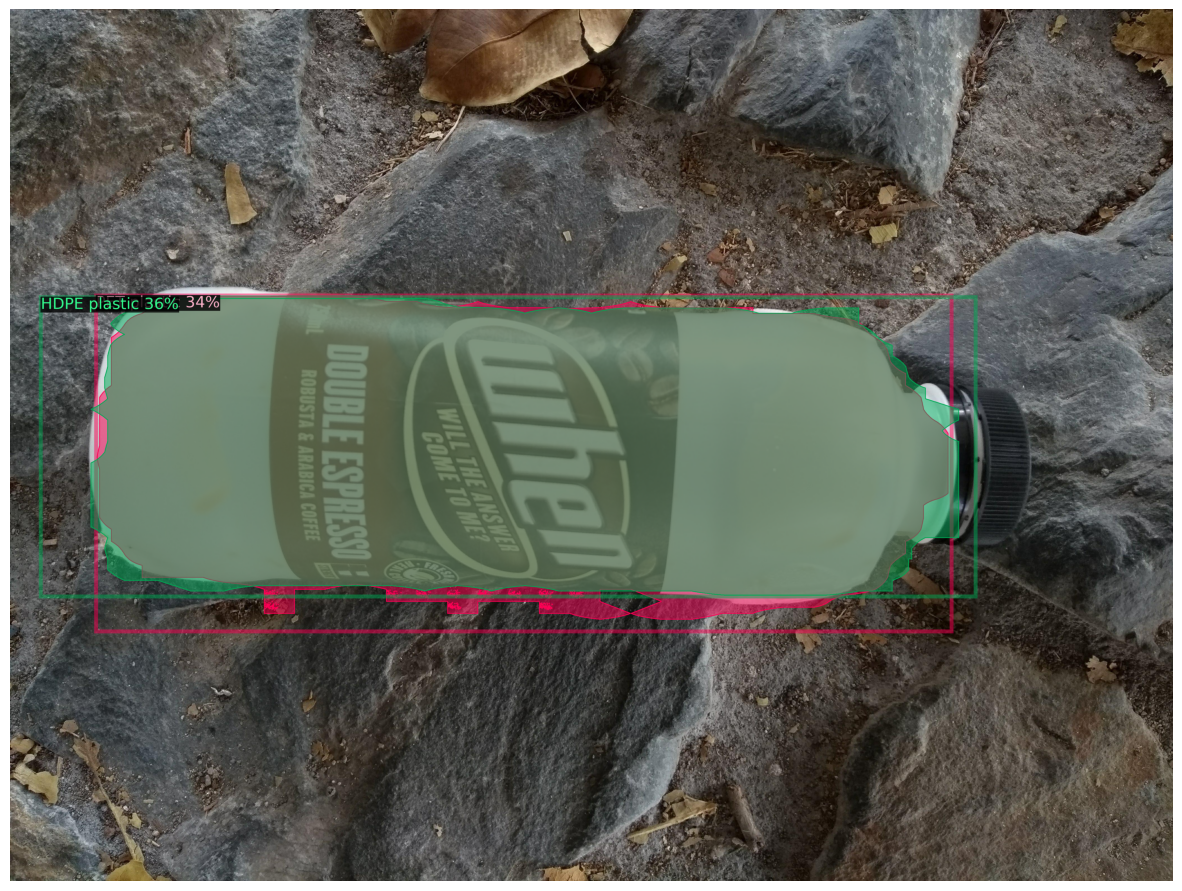

In [223]:
v = Visualizer(img, metadata=TACO_metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(15,15))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')

## Evaluation

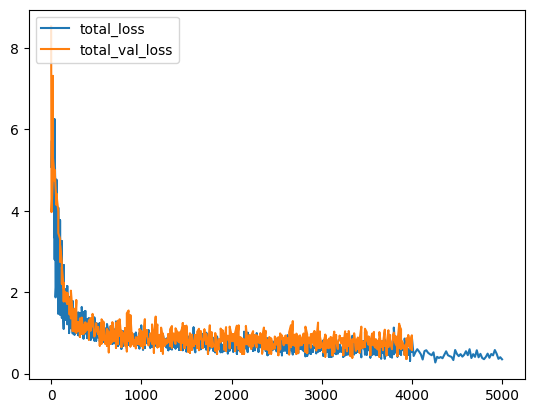

In [4]:
# Plot total_loss and validation_loss graph
experiment_folder = './output/mask_rcnn_fbnetv3g_fpn.yaml' # mask_rcnn_fbnetv3g_fpn

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
experiment_metrics.sort(key=lambda x: x['iteration'])

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_val_loss' in x], 
    [x['total_val_loss'] for x in experiment_metrics if 'total_val_loss' in x])
plt.legend(['total_loss', 'total_val_loss'], loc='upper left')
plt.show()




## Ground-truth segmentations

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
Number of instances:  1


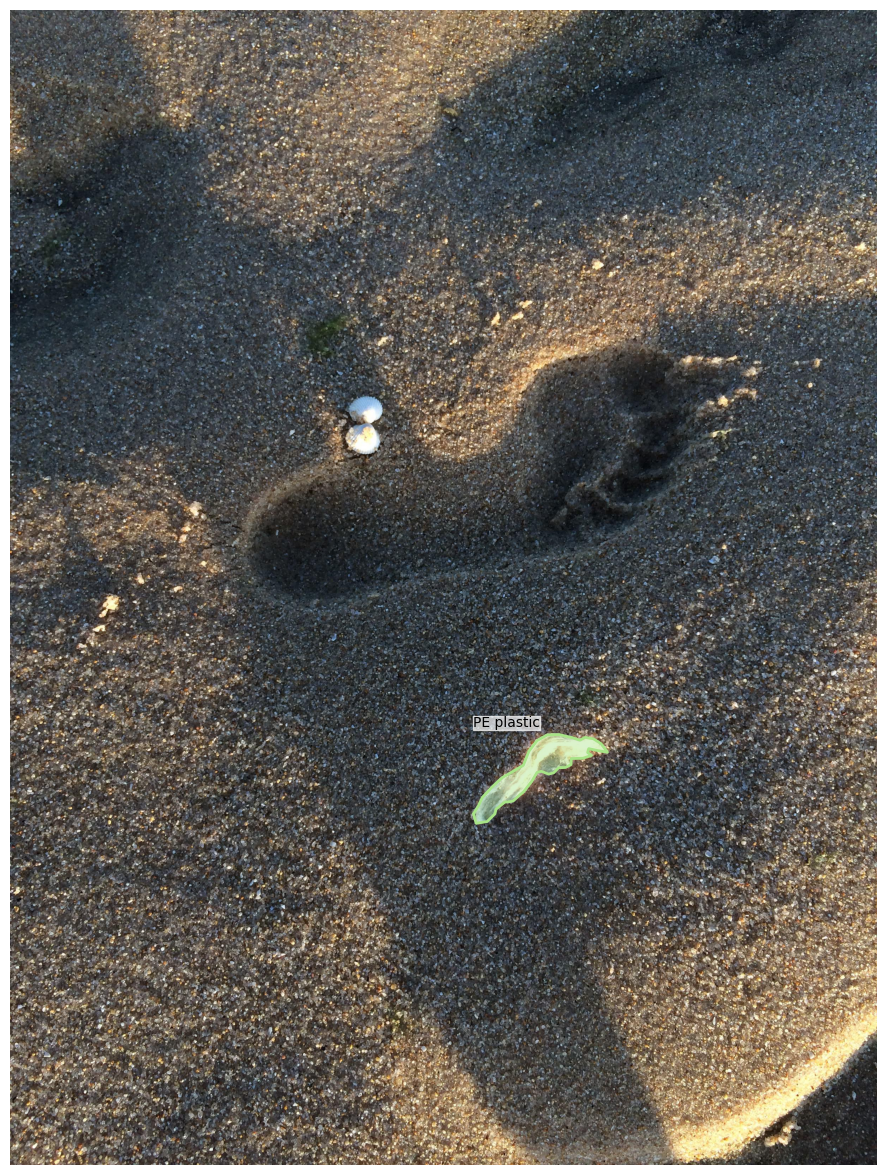

In [34]:
from pycocotools.coco import COCO

coco=COCO(anns_file_path)

catIds = coco.getCatIds()
imgIds = coco.getImgIds()
imgIds = coco.getImgIds(imgIds = imgIds[1361])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = plt.imread(dataset_path+img['file_name'])


plt.figure(figsize=(15,15))
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
print("Number of instances: ", len(anns))
for a in range(len(anns)):
    plt.text(anns[a]["bbox"][0], anns[a]["bbox"][1]-20 , cat_df.at[anns[a]["category_id"], "name"],
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='white', boxstyle='square,pad=0.0'),
            fontdict=dict(fontsize=10))
    
plt.axis('off')
coco.showAnns(anns,draw_bbox=False) # if bounding box will be shown, set draw_bbox=True


## Class count

<AxesSubplot: ylabel='val'>

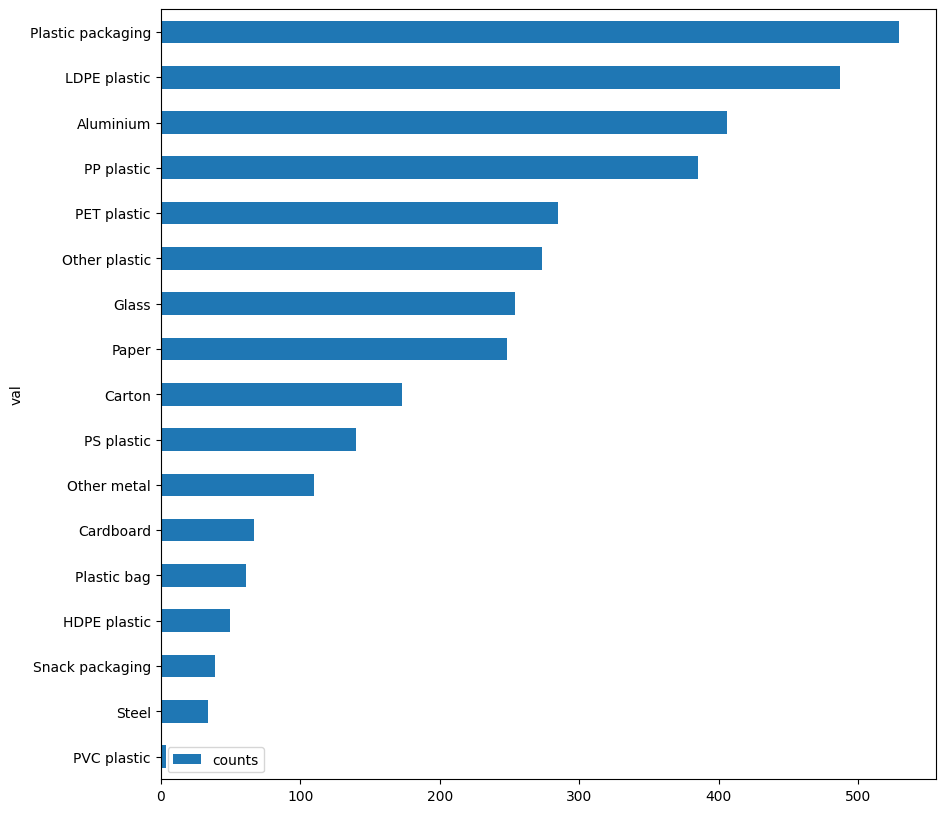

In [18]:
vals,counts=np.unique(ang_df["categories"],return_counts=True)
cat_count_df=pd.DataFrame(data={"val":vals,"counts":counts})
cat_count_df=cat_count_df.sort_values("counts")
cat_count_df.plot.barh(x="val",figsize=(10,10))

## Plot loss curve

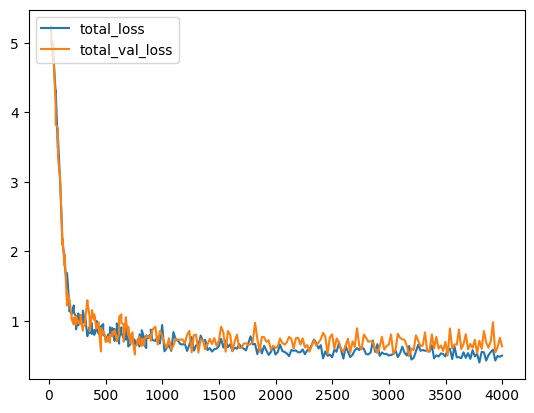

In [73]:
# Plot total_loss and validation_loss graph
experiment_folder = './output/mask_rcnn_fbnetv3a_C4.yaml'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')
experiment_metrics.sort(key=lambda x: x['iteration'])

plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_loss' in x], 
    [x['total_loss'] for x in experiment_metrics if 'total_loss' in x])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'total_val_loss' in x], 
    [x['total_val_loss'] for x in experiment_metrics if 'total_val_loss' in x])
plt.legend(['total_loss', 'total_val_loss'], loc='upper left')
plt.show()


